In [1]:
# Se importan las librerias
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from itertools import product
import matplotlib.pyplot as plt


In [2]:
N = 60       # Grid will be N x N
EMPTY = 0.1  # Fraction of vacant properties
B_to_R = 1   # Ratio of blue to red people

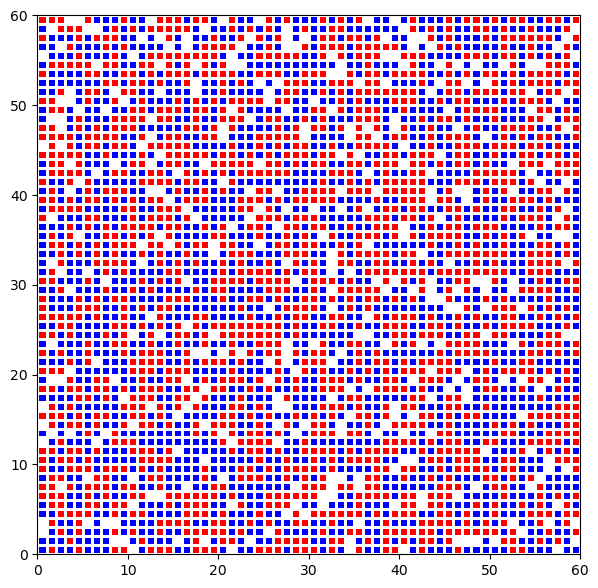

In [3]:
def rand_init(N, B_to_R, EMPTY):
    """ Inicialización aleatoria del sistema.
    BLUE  =  0
    RED   =  1
    EMPTY = -1
    """
    vacant = int(N * N * EMPTY)  # Calcula la cantidad de elementos vacantes en base al porcentaje EMPTY y el tamaño del sistema N
    population = N * N - vacant  # Calcula la población total restando los elementos vacantes al tamaño del sistema
    blues = int(population * 1 / (1 + 1/B_to_R))  # Calcula la cantidad de elementos azules en base a la proporción B_to_R
    reds = population - blues  # Calcula la cantidad de elementos rojos como el complemento de los elementos azules
    M = np.zeros(N*N, dtype=np.int8)  # Crea un arreglo de ceros del tamaño del sistema
    M[:reds] = 1  # Asigna los valores de 1 (rojo) a los primeros elementos del arreglo según la cantidad de elementos rojos
    M[-vacant:] = -1  # Asigna los valores de -1 (vacante) a los últimos elementos del arreglo según la cantidad de elementos vacantes
    np.random.shuffle(M)  # Mezcla aleatoriamente los elementos del arreglo
    return M.reshape(N,N)  # Devuelve el arreglo reorganizado en una matriz de tamaño N x N

M = rand_init(N, B_to_R, EMPTY)  # Llama a la función rand_init() para inicializar la matriz M

# Se ajustan los valores, para graficar el agente 1 como rojo, el agente 0 como azul
# y los vecinos vacíos como -1.

plt.figure(figsize=(7,7))  # Crea una figura con un tamaño específico
cmap = plt.cm.colors.ListedColormap(['White','blue','red'])
plt.pcolormesh(M, edgecolors='w', linewidth=1, cmap=cmap)  
plt.grid(which='minor', color='w', linestyle='-')  # Agrega una cuadrícula en color blanco al gráfico en las líneas menores


In [4]:
# Se define el kernel
KERNEL = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]], dtype=np.int8)

In [5]:
def evolve(M, SIM_T, boundary='wrap'):
    """
    Args:
        M (numpy.array): la matriz a evolucionar
        boundary (str): puede ser 'wrap', 'fill' o 'symm'
    Si la proporción de similitud de los vecinos
    con respecto a la población total de vecinos
    es menor que SIM_T,
    entonces el individuo se mueve a una casa vacía.
    """
    kws = dict(mode='same', boundary=boundary)
    
    # Calcula la cantidad de vecinos azules, rojos y totales utilizando convoluciones con el kernel
    B_neighs = convolve2d(M == 0, KERNEL, **kws)  # Vecinos azules
    R_neighs = convolve2d(M == 1, KERNEL, **kws)  # Vecinos rojos
    Neighs   = convolve2d(M != -1, KERNEL, **kws)  # Vecinos totales (excluyendo los vacantes)

    # Determina los individuos insatisfechos (que se mudarán) basándose en la similitud de vecinos
    B_dissatified = (B_neighs / Neighs < SIM_T) & (M == 0)  # Individuos azules insatisfechos
    R_dissatified = (R_neighs / Neighs < SIM_T) & (M == 1)  # Individuos rojos insatisfechos
    
    # Actualiza la matriz M: los individuos insatisfechos se mueven a casas vacantes
    M[R_dissatified | B_dissatified] = - 1
    
    # Calcula la cantidad de casas vacantes
    vacant = (M == -1).sum()

    # Determina la cantidad de individuos azules y rojos insatisfechos
    N_B_dissatified, N_R_dissatified = B_dissatified.sum(), R_dissatified.sum()
    
    # Genera un arreglo de rellenado con valores azules, rojos y vacantes
    filling = -np.ones(vacant, dtype=np.int8)
    filling[:N_B_dissatified] = 0
    filling[N_B_dissatified:N_B_dissatified + N_R_dissatified] = 1
    np.random.shuffle(filling)
    
    # Actualiza la matriz M: asigna los valores de rellenado a las casas vacantes
    M[M == -1] = filling
   
    return M


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16204\3893907140.py:19: RuntimeWarning: invalid value encountered in divide
  B_dissatified = (B_neighs / Neighs < SIM_T) & (M == 0)  # Individuos azules insatisfechos
C:\Users\Usuario\AppData\Local\Temp\ipykernel_16204\3893907140.py:20: RuntimeWarning: invalid value encountered in divide
  R_dissatified = (R_neighs / Neighs < SIM_T) & (M == 1)  # Individuos rojos insatisfechos


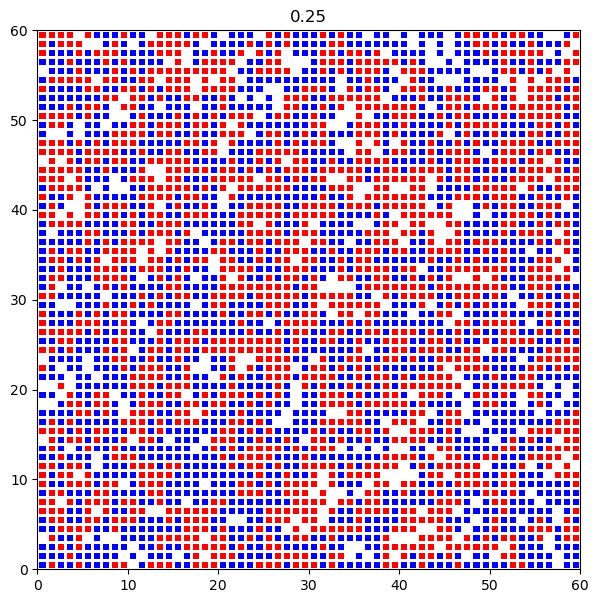

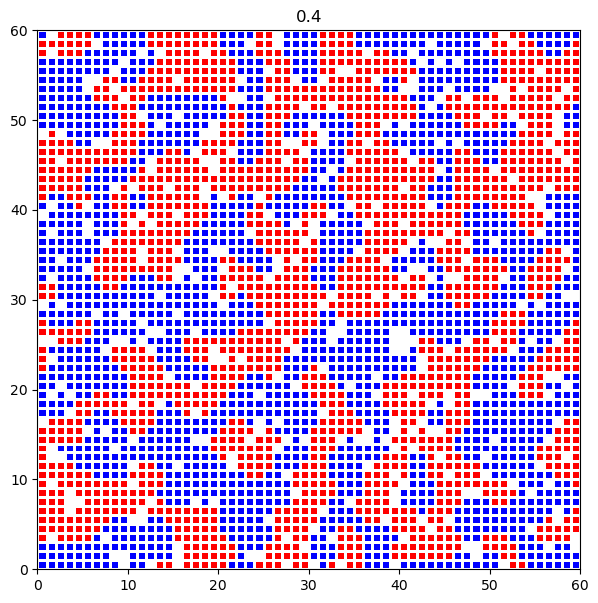

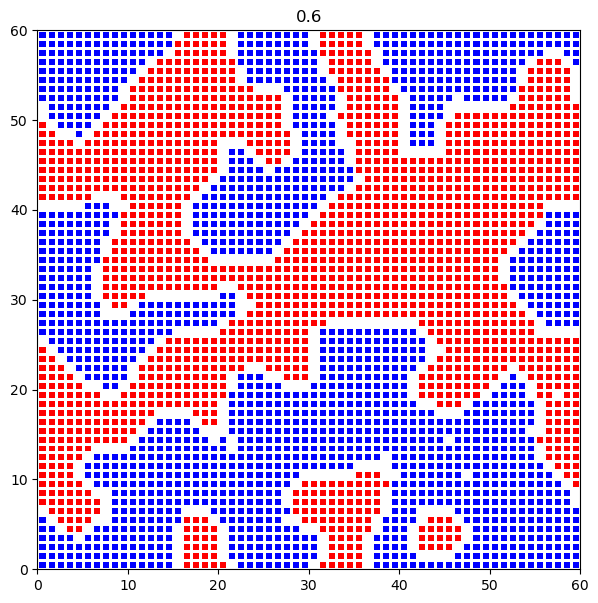

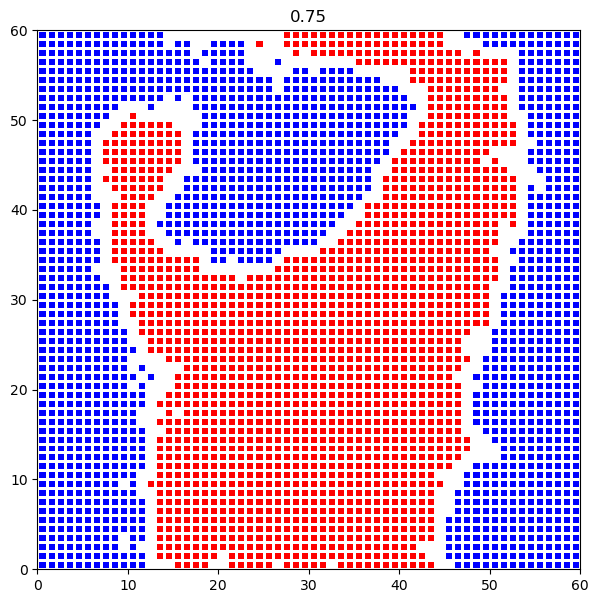

In [6]:
SIM_T = [0.25, 0.4, 0.6, 0.75]  # Umbral de similitud (es decir, 1-τ)

# Iterar sobre cada valor de SIM_T
for i in SIM_T:
    P1 = np.copy(M)
    for k in range(0, 500):
        P1 = evolve(P1, i, boundary='wrap')
        
    # Ajustar los valores para el gráfico de colores
    plt.figure(figsize=(7, 7))
    plt.pcolormesh(P1, edgecolors='w', linewidth=1, cmap=cmap)
    plt.title(str(i))


### Calculo satisfacción

In [7]:
def neighbours(arr, *coordinate):
    # Obtiene las coordenadas x, y del argumento "coordinate"
    x, y = coordinate[0], coordinate[1]
    
    # Obtiene las filas y columnas vecinas dentro de los límites del arreglo
    row = [i for i in range(x - 1, x + 2) if 0 <= i < len(arr)]
    col = [i for i in range(y - 1, y + 2) if 0 <= i < len(arr[0])]
    
    # Obtiene los vecinos excluyendo la coordenada actual (x, y)
    neighbours = set(product(row, col)) - {(x, y)}
    
    # Obtiene los valores de los vecinos en el arreglo
    return [arr[val[0]][val[1]] for val in neighbours]


def get_satisfaction(matrix):
    satisfaccion_promedio = []  # Lista para almacenar las satisfacciones individuales
    
    # Itera sobre las filas y columnas de la matriz
    for i, j in enumerate(matrix):
        for k, valor in enumerate(j):
            if valor == 0 or valor == 1:
                # Obtiene los vecinos del elemento en la posición (i, k)
                vecinos = neighbours(matrix, i, k)
                
                # Cuenta cuántos vecinos tienen el mismo valor que el elemento actual
                iguales = [i for i, e in enumerate(vecinos) if e == valor]
                
                # Calcular la satisfacción como el cociente de vecinos iguales entre el total de vecinos
                satisfaccion = len(iguales) / len(vecinos)
                
                # Agrega la satisfacción a la lista
                satisfaccion_promedio.append(satisfaccion)
    
    # Calcula el promedio de las satisfacciones individuales
    promedio = np.mean(satisfaccion_promedio)
    
    return promedio

### Curva de satisfacción

#### 1. Primera condición

In [8]:
# Definición de parámetros iniciales
EMPTY = 0.1  # Fracción de propiedades vacantes
B_to_R = 1 
SIM_T = np.linspace(0, 1, 100)

# Inicialización de la matriz M
M = rand_init(N, B_to_R, EMPTY)

# Matriz para almacenar las satisfacciones
curva_azul = np.zeros((100, 200))

# Bucle principal
for i in range(len(SIM_T)):
    # Imprime el valor de i si es divisible por 20
    if i % 20 == 0:
        print(i)
    
    # Copia la matriz M en P1
    P1 = np.copy(M)
    
    # Bucle para evolucionar P1
    for k in range(0, 200):
        # Evoluciona P1 utilizando la función evolve
        P1 = evolve(P1, SIM_T[i], boundary='wrap')
        
        # Calcula la satisfacción de P1
        s = get_satisfaction(P1)
        
        # Almacena la satisfacción en la matriz curva_azul
        curva_azul[i, k] = s
   
            

0
20


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16204\3893907140.py:19: RuntimeWarning: invalid value encountered in divide
  B_dissatified = (B_neighs / Neighs < SIM_T) & (M == 0)  # Individuos azules insatisfechos
C:\Users\Usuario\AppData\Local\Temp\ipykernel_16204\3893907140.py:20: RuntimeWarning: invalid value encountered in divide
  R_dissatified = (R_neighs / Neighs < SIM_T) & (M == 1)  # Individuos rojos insatisfechos


40
60
80


#### 2. Segunda condición

In [9]:
# Definición de parámetros iniciales
EMPTY = 0.1  # Fracción de propiedades vacantes
B_to_R = 0.25
M = rand_init(N, B_to_R, EMPTY)

# Matriz para almacenar las satisfacciones
curva_roja = np.zeros((100, 200))

# Bucle principal
for i in range(len(SIM_T)):
    # Imprime el valor de i si es divisible por 20
    if i % 20 == 0:
        print(i)
    
    # Copia la matriz M en P1
    P1 = np.copy(M)
    
    # Bucle para evolucionar P1
    for k in range(0, 200):
        # Evoluciona P1 utilizando la función evolve
        P1 = evolve(P1, SIM_T[i], boundary='wrap')
        
        # Calcula la satisfacción de P1
        s = get_satisfaction(P1)
        
        # Almacena la satisfacción en la matriz curva_roja
        curva_roja[i, k] = s


0
20
40


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16204\3893907140.py:19: RuntimeWarning: invalid value encountered in divide
  B_dissatified = (B_neighs / Neighs < SIM_T) & (M == 0)  # Individuos azules insatisfechos
C:\Users\Usuario\AppData\Local\Temp\ipykernel_16204\3893907140.py:20: RuntimeWarning: invalid value encountered in divide
  R_dissatified = (R_neighs / Neighs < SIM_T) & (M == 1)  # Individuos rojos insatisfechos


60
80


#### 3. Tercera condición

In [10]:
# Definición de parámetros iniciales
EMPTY = 0.02  # Fracción de propiedades vacantes
B_to_R = 1
M = rand_init(N, B_to_R, EMPTY)

# Matriz para almacenar las satisfacciones
curva_verde = np.zeros((100, 200))

# Bucle principal
for i in range(len(SIM_T)):
    # Imprime el valor de i si es divisible por 20
    if i % 20 == 0:
        print(i)
    
    # Copia la matriz M en P1
    P1 = np.copy(M)
    
    # Bucle para evolucionar P1
    for k in range(0, 200):
        # Evoluciona P1 utilizando la función evolve
        P1 = evolve(P1, SIM_T[i], boundary='wrap')
        
        # Calcula la satisfacción de P1
        s = get_satisfaction(P1)
        
        # Almacena la satisfacción en la matriz curva_verde
        curva_verde[i, k] = s
   

0
20
40
60
80


#### Figura satisfacción media

**En este código se realizan gráficos de línea para visualizar las medias de las curvas de satisfacción y también se representan las áreas sombreadas correspondientes a un intervalo de confianza definido por las desviaciones estándar.**

Text(0, 0.5, '<S>')

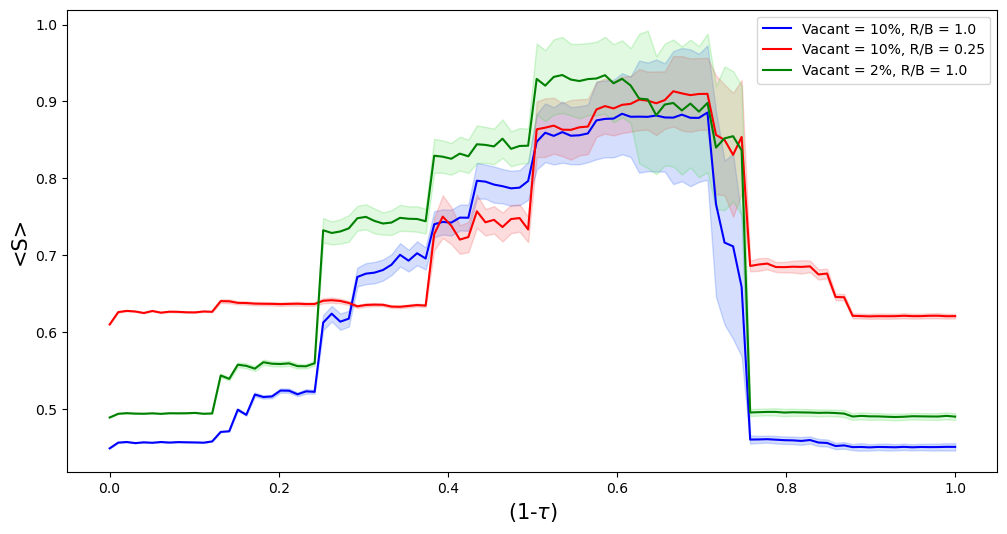

In [11]:
# Primera condicion
plt.figure(figsize=(12,6))
error_blue = np.std(curva_azul,axis=1)
y_blue = np.mean(curva_azul,axis=1)
plt.plot(SIM_T,y_blue,color='blue',label = 'Vacant = 10%, R/B = 1.0')
plt.fill_between(SIM_T, y_blue-error_blue, y_blue+error_blue,
    alpha=0.2, edgecolor='#0E4AFA', facecolor='#2E62F8')

# Segunda condicion
error_red = np.std(curva_roja,axis=1)
y_red = np.mean(curva_roja,axis=1)
plt.plot(SIM_T,y_red,color='red',label = 'Vacant = 10%, R/B = 0.25')
plt.fill_between(SIM_T, y_red-error_red, y_red+error_red,
    alpha=0.2, edgecolor='#EF3C3C', facecolor='#F35252')

# Tercera condicion
error_green = np.std(curva_verde,axis=1)
y_green = np.mean(curva_verde,axis=1)
plt.plot(SIM_T,y_green,color='green',label = 'Vacant = 2%, R/B = 1.0')
plt.fill_between(SIM_T, y_green-error_green, y_green+error_green,
    alpha=0.2, edgecolor='#29D42A', facecolor='#64E265')
plt.legend()
plt.xlabel(r'(1-$\tau$)',size=15)
plt.ylabel('<S>',size=15)

**Satisfacción media ⟨S⟩ por intolerancia creciente 1−τ . Los valores se promedian adicionalmente sobre 200 simulaciones de Monte Carlo, y las áreas sombreadas indican una desviación estándar alrededor de la media.**